In [1]:
from collections import defaultdict

In [2]:
# pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

c:\Users\youva\anaconda3\envs\pytorch-py3_8_19\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from models import ResNet
from plot_images import imshow
from modules import return_probabilities

In [4]:
transform = transforms.Compose([
        transforms.Resize(224),  # Resize to 224x224 for ResNet
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
    ])

In [16]:
classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

batch_size = 4

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)

Files already downloaded and verified


In [6]:
dataiter = iter(testloader)

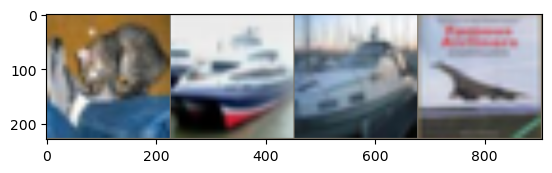

Actual:  cat   ship  ship  plane


In [7]:
# display some image examples
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(tensor=images))
print('Actual: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [8]:
# load the model and set it to evaluation mode
PATH = './cifar_resnet.pth'
net = ResNet()
net.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))  # trained on GPU which my PC doesn't have, weights are sent to CPU
net.eval()

c:\Users\youva\anaconda3\envs\pytorch-py3_8_19\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\youva\anaconda3\envs\pytorch-py3_8_19\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

In [9]:
images.requires_grad = True  # we will use the gradients to compute adverserial examples

In [10]:
logits = net(images)  # forward pass
probabilities, predicted_class = return_probabilities(logits)


GREEN = '\033[92m' # ANSI color codes
RED = '\033[91m'
BOLD = '\033[1m'
RESET = '\033[0m'  # Reset to default color
for i in range(batch_size):
   print(f"{BOLD}Image {i+1}: {classes[labels[i]]}{RESET}")
   print(f"Image {i+1} probabilities:")
   for j, prob in enumerate(probabilities[i]):
      if j == predicted_class[i]:
         if j == labels[i]:
            print(f"{GREEN}  {classes[j]}: {prob.item():.4f}{RESET}")
         else:
            print(f"{RED}  {classes[j]}: {prob.item():.4f}{RESET}")
      else:
         print(f"  {classes[j]}: {prob.item():.4f}")

Image 1: cat
Image 1 probabilities:
  plane: 0.0155
  car: 0.0027
  bird: 0.0764
  cat: 0.3460
  deer: 0.0033
  dog: 0.4884
  frog: 0.0137
  horse: 0.0366
  ship: 0.0128
  truck: 0.0046
Image 2: ship
Image 2 probabilities:
  plane: 0.0162
  car: 0.3724
  bird: 0.0001
  cat: 0.0000
  deer: 0.0000
  dog: 0.0000
  frog: 0.0000
  horse: 0.0000
  ship: 0.6089
  truck: 0.0022
Image 3: ship
Image 3 probabilities:
  plane: 0.0301
  car: 0.0039
  bird: 0.0003
  cat: 0.0003
  deer: 0.0033
  dog: 0.0001
  frog: 0.0000
  horse: 0.0019
  ship: 0.9452
  truck: 0.0148
Image 4: plane
Image 4 probabilities:
  plane: 0.7075
  car: 0.0025
  bird: 0.1863
  cat: 0.0125
  deer: 0.0035
  dog: 0.0001
  frog: 0.0074
  horse: 0.0015
  ship: 0.0769
  truck: 0.0018


### Quick adverseral examples - Fast Gradient Sign Method

In [11]:
# for now let's try to get all images missclassified as dog
target_class = 5  # class 5 = dog
loss = nn.functional.cross_entropy(logits, torch.full_like(labels, target_class))
loss.backward()

In [12]:
epsilon = 0.01
adversarial_images = images + epsilon * images.grad.sign()
adversarial_images = torch.clamp(adversarial_images, 0, 1)  # restrict pixel values to valid range, we will see more advanced restrictions later

In [13]:
# Test the adversarial examples
with torch.no_grad():
    adverserial_logits = net(adversarial_images)
    adverserial_probabilities, adverseral_predicted_class = return_probabilities(adverserial_logits)

Actual Images:


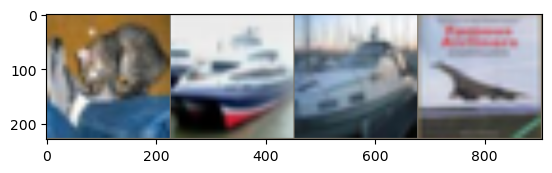


Adversarial Example Predictions:


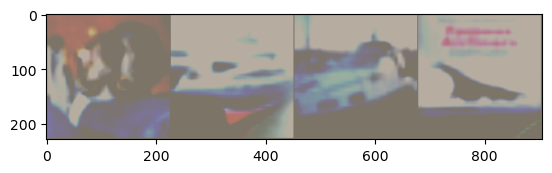

Image 1: cat
Image 1 probabilities:
  plane: 0.1459
  car: 0.0002
  bird: 0.0876
  cat: 0.2245
  deer: 0.4843
  dog: 0.0200
  frog: 0.0061
  horse: 0.0021
  ship: 0.0291
  truck: 0.0002
Image 2: ship
Image 2 probabilities:
  plane: 0.6478
  car: 0.0000
  bird: 0.3203
  cat: 0.0065
  deer: 0.0061
  dog: 0.0006
  frog: 0.0056
  horse: 0.0002
  ship: 0.0127
  truck: 0.0000
Image 3: ship
Image 3 probabilities:
  plane: 0.6389
  car: 0.0002
  bird: 0.1020
  cat: 0.0514
  deer: 0.0364
  dog: 0.0008
  frog: 0.0081
  horse: 0.0041
  ship: 0.1575
  truck: 0.0005
Image 4: plane
Image 4 probabilities:
  plane: 0.5503
  car: 0.0000
  bird: 0.4224
  cat: 0.0032
  deer: 0.0100
  dog: 0.0005
  frog: 0.0019
  horse: 0.0034
  ship: 0.0080
  truck: 0.0002


In [14]:
print("Actual Images:")
imshow(torchvision.utils.make_grid(tensor=images))
print("\nAdversarial Example Predictions:")
imshow(torchvision.utils.make_grid(tensor=adversarial_images))

for i in range(batch_size):
   print(f"{BOLD}Image {i+1}: {classes[labels[i]]}{RESET}")
   print(f"Image {i+1} probabilities:")
   for j, prob in enumerate(adverserial_probabilities[i]):
      if j == adverseral_predicted_class[i]:
         if j == labels[i]:
            print(f"{GREEN}  {classes[j]}: {prob.item():.4f}{RESET}")
         else:
            print(f"{RED}  {classes[j]}: {prob.item():.4f}{RESET}")
      else:
         print(f"  {classes[j]}: {prob.item():.4f}")

In [19]:
# overall accuracy of our model if we apply an adverserial attack to each input image
target_class = 5 
epsilon = 0.01

correct = 0
adverserial_correct = 0
total = 0

# for per class accuracies
class_correct = defaultdict(int)
adv_class_correct = defaultdict(int)
class_total = defaultdict(int)

for data in testloader:
    images, labels = data
    images.requires_grad = True
    logits = net(images)
    _, predicted_class = torch.max(logits.data, 1)  # logits.data prevents us from accidently affecting the computational graph

    # preform the attack
    loss = nn.functional.cross_entropy(logits, torch.full_like(labels, target_class))
    net.zero_grad()  # zero the gradients before the attack to prevent accumulation, is this necessary?
    loss.backward()
    adversarial_images = images + epsilon * images.grad.sign()
    adversarial_images = torch.clamp(adversarial_images, 0, 1)
    with torch.no_grad():
        adverserial_logits = net(adversarial_images)
        _, adverserial_predicted_class = torch.max(adverserial_logits.data, 1)  # already within torch.no_grad()
    
    total += labels.size(0)
    correct += (predicted_class == labels).sum().item()
    adverserial_correct += (adverserial_predicted_class == labels).sum().item()

    for label, pred, adv_pred in zip(labels, predicted_class, adverserial_predicted_class):
        label = label.item()
        class_total[label] += 1
        class_correct[label] += (pred == label).item()
        adv_class_correct[label] += (adv_pred == label).item()

    if total % 32 == 0:
        print(f"{total}/10000 images complete")
        print("Actual Images:")
        imshow(torchvision.utils.make_grid(tensor=images))
        print("\nAdversarial Example Predictions:")
        imshow(torchvision.utils.make_grid(tensor=adversarial_images))


print(f'\nAccuracy of the network on the 10000 test images: {100 * correct // total} %')
print(f'\nAccuracy of the network on the 10000 attacked test images: {100 * adverserial_correct // total} %')

print('\nPer-class accuracies:')
for i in range(len(classes)):
    if class_total[i] > 0:
        print(f'Class {classes[i]}:')
        print(f'  Original accuracy: {100 * class_correct[i] / class_total[i]:.2f}%')
        print(f'  Adversarial accuracy: {100 * adv_class_correct[i] / class_total[i]:.2f}%')

KeyboardInterrupt: 